In [1]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
from functions import *
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
df = pd.read_csv('train.csv')
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

Assumptions & key points
- Conditional Indipendence Assumption: There are no unobserved differences correlated to potential outcomes once we have controlled for certain observable characteristics
- Participation can be considered random among observations with the same characteristics
- Identification condition: observations with similar characteristics X present in both treatment and control groups. This requires 0 < P(T=1|X) < 1
- Selection on treatment (or not) should be solely based on observable characteristics (i.e. X). Assuming there is no selection bias from unobserved characteristics. It is not possible to prove the validity of this unconfoundedness assumption.
- There is a cost in not doing RCT (randomised controlled testing)
- Curse of dimensionality -> propensity score matching
- Prop. score: propability of participating in the treatment based on observable characteristics (i.e. X)

In [4]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
# Treatment effect: passenger has cabin (1) or not (0)
df['treatment'] = df.Cabin.apply(hasCabin)

In [6]:
# There is high correlation between treatment (i.e. hasCabin) and Class.
# This is desirable in this case as it plays the role of the systematic factor affecting the treatment.
# In a different context this could be a landing page on site that only specific visitors see.
pd.pivot_table(df[['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1,2,3
treatment,,,
0,158,15,10
1,26,158,345


In [7]:
# Keeping only specific variables
# We should account for all variables that affect the treatment variable (i.e. hasCabin)
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass']]

In [8]:
T = df_data.treatment
X = df_data.drop(columns = ['treatment'])

In [9]:
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=True)

In [10]:
# X_encoded.loc[1,:]

In [11]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [12]:
predictions = pipe.predict_proba(X_encoded)

In [13]:
predictions[0:2]

array([[0.02327748, 0.97672252],
       [0.85724206, 0.14275794]])

In [14]:
# Convert propability to logit. Based on 
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

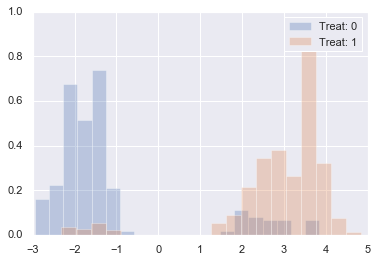

In [15]:
for i in range(2):
    plt.hist(predictions_logit[T == i], density= True , alpha=0.3, label = 'Treat: {}'.format(pipe.classes_[i]), bins = 20)
plt.legend()

In [16]:
# There is overlap only between 1 and 4 for logit propensity score. This is the common support area where Propensity Score matching will apply

In [44]:
common_support = (predictions_logit > 1) & (predictions_logit < 4)

In [45]:
dt = pd.DataFrame(data = {'propensity_score': predictions[:,1],'propensity_score_logit': predictions_logit, \
                          'outcome': y.Survived, 'treatment': T}, index = y.index)

In [46]:
dt.head()

,propensity_score,propensity_score_logit,outcome,treatment
0,0.976723,3.736716,0,1
1,0.142758,-1.792570,1,0
2,0.956826,3.098374,1,1
3,0.119580,-1.996418,1,0
4,0.977179,3.756975,0,1


In [47]:
# pd.pivot_table(df.iloc[common_support][['treatment','Pclass','PassengerId']], \
#               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
#               aggfunc= np.count_nonzero)

In [48]:
X.loc[common_support].head(2)

,Sex,Age,SibSp,Parch,Embarked,Pclass
0,male,22.0,1,0,S,3
2,female,26.0,0,0,S,3


In [49]:
# sns.barplot(x = dt['outcome'], y = dt['propensity_score'], hue = dt['treatment'])

In [50]:
# dt.iloc[common_support][['propensity_score']].to_numpy()

## Matching Implementation
Use Nearerst Neighbors to perform 1-to-1 matching. 

In [51]:
caliper = np.std(dt.propensity_score) * 0.20
print('Caliper is: {}'.format(caliper))

dt = dt.loc[common_support].reset_index().rename(columns = {'index':'old_index'})

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(dt[['propensity_score']].to_numpy())

Caliper is: 0.0701812361092277


NearestNeighbors(n_neighbors=10, radius=0.0701812361092277)

In [52]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    dt[['propensity_score']].to_numpy(), \
    n_neighbors=10)

In [53]:
# for d in distances[10,:]:
#    print('{:.6f}'.format(d))

In [54]:
# indexes[10,:]   

In [55]:
# dt.loc[10]

In [56]:
# dt.loc[478]

In [57]:
# dt.head()

In [58]:
print('{:.6f}'.format(dt.loc[10].propensity_score - dt.loc[478].propensity_score))

-0.000048


In [61]:
pd.DataFrame(data = indexes)

,0,1,2,3,4,5,6,7,8,9
0,0,33,311,119,428,266,501,59,422,402
1,1,183,37,152,421,497,17,129,150,440
2,329,2,340,210,383,26,177,73,432,416
3,3,108,438,388,474,378,120,387,317,178
4,4,147,128,131,244,106,505,315,503,195
...,...,...,...,...,...,...,...,...,...,...
502,502,312,83,215,273,153,262,247,320,362
503,503,315,195,299,147,310,133,506,4,226
504,504,162,442,441,44,446,347,379,95,287
505,505,128,106,131,244,256,377,4,147,39


In [60]:
def perfom_matching(df):
    df_source = df.copy(deep = True)
    
    df_destination = df.copy(deep = True)
    df_destination = df_destination.loc[df_destination.treatment == 0]
    
    df_destination
    pd.merge()
    